<a href="https://colab.research.google.com/github/avega17/CCOM_MS_Spring_2025_EO_PV_research/blob/main/pv_segm_smp_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Computer Vision methods for Planetary-scale surveys of PV Solar Panels

*CCOM6120: Computer Vision*  
**Alejandro Vega Nogales**  
*Data Scientist @ Maxar Puerto Rico*   
*CCOM MS Student*

In [30]:
!pip install -r requirements.txt

  Using cached cloud_tpu_client-0.10-py3-none-any.whl.metadata (1.2 kB)
  Using cached earthengine_api-1.5.14-py3-none-any.whl.metadata (2.1 kB)
  Using cached torch_xla-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (21 kB)
INFO: pip is looking at multiple versions of cloud-tpu-client to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.6/462.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.5.13
    Uninstalling earthengine-api-1.5.13:
      Successfully uninstalled earthengine-api-1.5.13


In [32]:
!pip install torch_xla

In [34]:
if 'google.colab' in str(get_ipython()):
    import os
    print('Running on CoLab')
    from google.colab import drive
    from google.colab import userdata
    # enable TPU accelerators
    # import torch
    # import torch_xla.core.xla_model as xm

    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/CCOM_MS_Spring_2025_EO_PV_research/')

Running on CoLab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Research Problem & Motivation

### Importance of monitoring and tracking Renewable Energy Installations

As the world transitions to renewable energy sources, solar photovoltaic (PV) installations are growing exponentially worldwide. Accurate mapping and monitoring of these installations  
is crucial for energy planning, grid management, carbon accounting, and sustainable development. However, traditional methods of tracking PV installations rely on incomplete permit data,  
manual surveys, or voluntary reporting—all of which present significant gaps in coverage and accuracy.

### Global Significance

Accurate mapping of solar PV installations has far-reaching implications:

- **Energy transition monitoring**:     Tracking actual deployment rates of solar PV against climate targets
- **Grid integration**:
    - Precise location of distributed energy resources for power system planning
    - Short-term forecasting of PV power generated (via solar flux estimates) for countries with high PV integration in their grid is essential for maintaining grid stability
- **Environmental impact assessment**:
    - Understanding land use changes and habitat effects of renewable energy development
- **Socioeconomic analysis**:
    - Studying adoption patterns across different communities to inform equitable energy transition policies
- **Sustainable Development Goals**:
   - Contributing to efforts that can directly address the UN's SDG 7 (Affordable and Clean Energy) and SDG 13 (Climate Action)

### The role of Remote Sensing and Computer Vision

Remote sensing and computer vision techniques can provide a scalable and efficient solution to monitor and map solar PV installations. By leveraging high-resolution satellite imagery, we can automate the detection and classification of solar panels, enabling large-scale assessments of solar energy deployment.

...

### The Challenge of PV Segmentation

Satellite imagery offers a promising solution for automated detection of PV installations at regional and global scales. Yet, several challenges make this a non-trivial computer vision problem:

1. **Multi-scale challenge**: PV installations vary dramatically in size, from small residential rooftop panels (a few m²) to utility-scale solar farms (several km²)
2. **Visual variability**: PV panels appear differently depending on panel type, orientation, age, viewing angle, and illumination conditions
3. **Resolution trade-offs**: As demonstrated in Clark et al.'s study (2023), detection performance is strongly affected by image resolution, creating a compromise between coverage area and detection accuracy
4. **Class imbalance**: PV installations typically occupy a small fraction of any given geographic area, creating extreme class imbalance in training data
5. **Data scarcity**: High-quality labeled datasets for training are limited and geographically biased toward certain regions

<figure style="text-align: center">
<img src="https://github.com/avega17/CCOM_MS_Spring_2025_EO_PV_research/blob/main/report/assets/figures/Munich_2021-06-18_WV03_HD_16x9.jpg?raw=1" style="width:70%; height:auto;">
<figcaption align = "center"> 31cm native resolution vs simulated "15.5"cm spatial resolution from our dataset</figcaption>
</figure>

### Related Work and Background

In their seminal work with very high resolution (VHR) satellite imagery *(< 1 meter/pixel*), Cecilia Clark and Fabio Pacifici (2023) demonstrated that resolution significantly impacts detection performance, with our employer's (Maxar Intelligence) ["HD Technology" product](https://blog.maxar.com/tech-and-tradecraft/2022/maxars-hd-technology-provides-measurable-improvements-in-machine-learning-applications) (proprietary upscaling algorithm capable of simulating 15.5cm GSD) delivering substantially better results than native resolution (31cm) imagery. This **resolution-performance trade-off** informs our approach to developing models that can work effectively across varying image resolutions. They summarize the challenges succinctly below:

**"Residential solar panels are considered small, weak targets even in VHR satellite imagery due to the average number of pixels per object, variation among  
objects, and complex context**. *Existing satellite imagery datasets often include large-scale, or non-residential, solar panel annotations* due to resolution  
of the imagery and therefore ability to detect small objects. There are available datasets of VHR imagery to support accurate detection
of small-scale and residential installations, but **the imagery is generally sourced from aerial platforms.**"

By establishing baseline segmentation techniques in preparation for more advanced models, this research contributes to the broader goal of creating comprehensive, accurate, and timely inventories of global PV installations—a critical capability for managing the ongoing energy transition.

<figure style="text-align: center">
<img src="https://github.com/avega17/CCOM_MS_Spring_2025_EO_PV_research/blob/main/report/assets/figures/maxar_hd_vs_native_comparison.jpg?raw=1" style="width:70%; height:auto;">
</figure>
<figure style="text-align: center">
<img src="https://github.com/avega17/CCOM_MS_Spring_2025_EO_PV_research/blob/main/report/assets/figures/maxar_hd_vs_native_comparison2.jpg?raw=1" style="width:70%; height:auto;">
<figcaption align = "center"> 31cm native resolution vs simulated "15.5"cm spatial resolution from our dataset</figcaption>
</figure>

### Research Questions

This project aims to address the following key questions:

1. How can we leverage *SOTA DL architectures* to improve PV segmentation accuracy across diverse geographic regions including **regions with sparse data**?

2. Can *PyTorch's Lightning framework* enable more **efficient experimentation across multiple model architectures** to efficiently identify optimal approaches for this domain-specific problem?

3. What **combination of data augmentation strategies, model architectures, loss functions, and training approaches** best addresses the unique challenges of PV segmentation?

4. How can we optimize models to work effectively across **different spatial resolutions** while maximizing the area that can be covered in operational settings?

<figure style="text-align: center">
<div style="display: flex; flex-direction: row; gap: 20px; width: 100%;">
    <div style="flex: 1; text-align: center;">
        <img src="https://github.com/avega17/CCOM_MS_Spring_2025_EO_PV_research/blob/main/report/assets/figures/Planet_MS_global_renewables_watch_lo_res_comparison.png?raw=1" style="width: 100%; height: auto;">
        <p>Imagery available in Global Renewables Watch atlas</p>
    </div>
    <div style="flex: 1; text-align: center;">
        <img src="https://github.com/avega17/CCOM_MS_Spring_2025_EO_PV_research/blob/main/report/assets/figures/maxar_mgp_renewables_planet_comparison.png?raw=1" style="width: 100%; height: auto;">
        <p> Blue + RedEdge + NIR composite from Maxar Geospatial Platform </p>
    </div>
</div>
<figcaption align = "center">  PV imagery: PlanetLabs Dove vs Maxar Worldview-3  </figcaption>
</figure>


<!-- <div style="display: flex; flex-direction: row; gap: 20px; width: 100%;">
    <div style="flex: 1; text-align: center;">
        <img src="report/assets/figures/unetplusplus_architecture.png" style="width: 100%; height: auto;">
        <p>UNet++ Architecture</p>
    </div>
    <div style="flex: 1; text-align: center;">
        <img src="report/assets/figures/deeplabv3plus_architecture.png" style="width: 100%; height: auto;">
        <p>DeepLabV3+ Architecture</p>
    </div>
</div> -->

# PV Segmentation with Torch Lightning & SMP

This notebook provides a framework for training and evaluating deep learning models for solar photovoltaic (PV) panel segmentation from satellite imagery. It leverages the power and flexibility of PyTorch Lightning for streamlined training and `segmentation-models-pytorch` (SMP) for easy access to a wide variety of cutting-edge model architectures.

This notebook will demonstrate the benefits of using PyTorch Lightning for organizing code and simplifying complex training workflows, and leveraging `segmentation-models-pytorch` (SMP) allows for rapid experimentation with different model backbones and architectures.

**Key Goals for this Notebook:**
1.  **Data Preparation:** Set up a PyTorch Lightning DataModule to efficiently load and preprocess image patches and their corresponding masks derived from the datasets listed above (or similar).
2.  **Model Definition:** Define a reusable PyTorch LightningModule that can accommodate various segmentation architectures from `segmentation-models-pytorch`.
3.  **Training:** Execute training loops, leveraging PyTorch Lightning's features for hardware acceleration (including Apple Silicon MPS), logging, and checkpointing.
4.  **Evaluation:** Assess model performance using relevant metrics and visualize predictions.
5.  **Logging with Weights & Biases:** Track experiments and log metrics using Weights & Biases.

**Assumptions for this Notebook:**
*   Image patches and their corresponding binary masks are assumed to be pre-prepared (e.g., using the `fetch-pv-datasets-ESDA.ipynb` notebook or similar methods) and stored in specified directories.
*   The notebook is designed to be adaptable for different datasets, such as those derived from Maxar imagery with YOLO labels converted to masks, or other datasets providing pixel-coordinate labels that have been rasterized to masks.


In [46]:
# -*- coding: utf-8 -*-
# %% --- 1. Setup & Imports ---
# Standard libraries
import os
import time
from pathlib import Path
import warnings
import json
import shutil
import traceback

# Geospatial libraries (primarily for data prep, less so for core training loop if data is pre-processed)
# import geopandas as gpd # Keep if your label_gpkg_path is used to derive file lists
import xarray as xr
import rasterio # For reading image patches
# import rioxarray as rxr
# import pystac_client
# import cubo
# import shapely

# ML/DL libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, SoftBCEWithLogitsLoss
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryJaccardIndex, BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from lightning.pytorch import Trainer

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

from utils.fetch_and_preprocess import (
    yolo_labels_to_binary_mask,
    process_yolo_label_directory
)
from utils.torch_datasets import PVSegmentationDataset, PVSegmentationDataModule

from dotenv import load_dotenv

# --- Suppress specific warnings ---
warnings.filterwarnings("ignore", category=UserWarning, module="rasterio")
warnings.filterwarnings("ignore", message=".* Shapely GEOS version .*")
# Suppress the NotGeoreferencedWarning specifically
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

In [47]:
# %% --- 1.5 Dataset resolution and model+encoder selection ---

# User lighter combos locally and larger for colab
default_arch = "Linknet"
default_encoder = "resnet18"
if 'google.colab' in str(get_ipython()):
    default_arch = "UnetPlusPlus"
    default_encoder
# Create radio buttons for selecting model architecture
model_arch_radio = widgets.RadioButtons(
    options=[
        'Unet', 'UnetPlusPlus',
        'FPN', 'Linknet', 'PSPNet',
        'DeepLabV3Plus', 'MAnet', 'PAN',
        'Segformer', 'DPT'
    ],
    value=default_arch,
    description='Model Architecture:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Create radio buttons for selecting encoder
encoder_radio = widgets.Dropdown(
    options=['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
             'resnext50_32x4d', 'resnext101_32x8d', 'resnext101_64x4d',
             'mobilenet_v2', 'efficientnet-b0', 'timm-tf_efficientnet_lite4'
             'vgg16', 'vgg19', 'vgg16_bn',
             'densenet121', 'densenet169', 'densenet201', 'densenet161',
            # ViT encoders compatible with DPT
             'tu-fastvit_sa36.apple_dist_in1k',
             'tu-efficientformer_l3.snap_dist_in1k',
             'tu-swin_large_patch4_window7_224.ms_in22k_ft_in1k',
             'tu-swinv2_large_window12to16_192to256.ms_in22k_ft_in1k',
             'tu-vitamin_large2_224.datacomp1b_clip',
             'tu-vit_medium_patch16_clip_224.tinyclip_yfcc15m',
             'tu-xcit_large_24_p8_384.fb_dist_in1k',
             'tu-twins_svt_base.in1k',
             ],
    value=default_encoder,
    description='Encoder:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Optional: update selections interactively
def on_arch_change(change):
    print(f"Selected Model Architecture: {change['new']}")

def on_encoder_change(change):
    print(f"Selected Encoder: {change['new']}")

model_arch_radio.observe(on_arch_change, names='value')
encoder_radio.observe(on_encoder_change, names='value')

# Display the radio button widgets
display(model_arch_radio)
display(encoder_radio)

# Function to handle dropdown selection changes
SELECTED_RESOLUTION_TYPE = 'native' if torch.backends.mps.is_available() else 'hd'

# Create a dropdown widget for resolution selection
resolution_dropdown = widgets.Dropdown(
    options=[
        ('HD (15.5cm simulated)', 'hd'),
        ('Native (31cm)', 'native')
    ],
    value=SELECTED_RESOLUTION_TYPE,
    description='Resolution:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Create a label widget to explain the purpose
description_html = widgets.HTML(
    value="""<p style="margin-bottom:10px">
    Select which Maxar imagery resolution to use for model training.
    HD refers to Maxar's proprietary upscaling algorithm that simulates 15.5cm ground sample distance.
    </p>"""
)

def on_resolution_change(change):
    global SELECTED_RESOLUTION_TYPE
    SELECTED_RESOLUTION_TYPE = change['new']
    print(f"Selected resolution: {SELECTED_RESOLUTION_TYPE}")

resolution_dropdown.observe(on_resolution_change, names='value')

# Display the widgets
display(description_html)
display(resolution_dropdown)

RadioButtons(description='Model Architecture:', index=1, layout=Layout(width='300px'), options=('Unet', 'UnetP…

Dropdown(description='Encoder:', layout=Layout(width='300px'), options=('resnet18', 'resnet34', 'resnet50', 'r…

HTML(value='<p style="margin-bottom:10px">\n    Select which Maxar imagery resolution to use for model trainin…

Dropdown(description='Resolution:', layout=Layout(width='300px'), options=(('HD (15.5cm simulated)', 'hd'), ('…

In [48]:
# %% --- 2. Configuration and Setup ---

# Load environment variables from .env file
load_dotenv()
print(os.environ.items())

# --- Data Parameters ---
# These paths point to pre-prepared image patches and their corresponding masks
# For initial testing with datasets like Maxar's (Clark et al.) or Jiang et al.,

print(f"Using {SELECTED_RESOLUTION_TYPE} resolution for training.")

# choose native or transformed "hd" chips and labels
MASK_DIR = Path(os.getenv('MAXAR_PV_YOLO_LABELS', 'datasets/raw/labels/maxar_hd_south_germany_PV_OD'))
MASK_DIR = MASK_DIR / 'labels_hd' if SELECTED_RESOLUTION_TYPE == 'hd' else MASK_DIR / 'labels_native'
IMAGE_PATCH_DIR = Path(os.getenv('MAXAR_PV_CHIPS_PATH', 'datasets/raw/images/maxar_hd_south_germany_PV_OD'))
IMAGE_PATCH_DIR = IMAGE_PATCH_DIR / 'image_chips_hd' if SELECTED_RESOLUTION_TYPE == 'hd' else IMAGE_PATCH_DIR / 'image_chips_native'
CHECKPOINT_DIR = Path(os.getenv('MODEL_CHECKPOINTS_DIR', 'datasets/model_artifacts/checkpoints'))

print(f"Using {IMAGE_PATCH_DIR} for image patches with {len(os.listdir(IMAGE_PATCH_DIR))} images.")
print(f"Using {MASK_DIR} for labels with {len(os.listdir(MASK_DIR))} masks.")

# LABEL_FILE_PATH is not directly used by DataModule if image/mask paths are directly globbed,
# but can be useful for cross-referencing or generating file lists.
# LABEL_FILE_PATH = 'path/to/your/pv_labels.gpkg'

PATCH_SIZE_PIXELS = 832 if SELECTED_RESOLUTION_TYPE == 'hd' else 416 # Adjust based on resolution
NUM_WORKERS = os.cpu_count() // 2 if os.cpu_count() else 0 # For DataLoaders

print(f"Using chip size of {PATCH_SIZE_PIXELS} pixels and loading with {NUM_WORKERS} workers.")

# --- Model & Training Hyperparameters (Common) ---
IN_CHANNELS = 3 # RGB. Change to 4 if using RGB+NIR
NUM_CLASSES = 1 # Binary segmentation (PV vs background)
TARGET_ACTIVATION = 'sigmoid' # Output activation for the model (sigmoid is recommended for binary segmentation, softmax for multi-class)

LEARNING_RATE = 1e-4
BATCH_SIZE = 8 # Adjust based on GPU/MPS memory
NUM_EPOCHS = 30 # Start with very few epochs for initial weekend testing
VAL_SPLIT_RATIO = 0.2
USE_TORCH_COMPILE = 'reduce-overhead' # Options: False, True (uses default), 'reduce-overhead', 'max-autotune'
WANDB_PROJECT_NAME = os.getenv("WANDB_PROJECT", "CV-PV segmentation baselines")
# WANDB_ENTITY = os.getenv("WANDB_ENTITY", "your_wandb_entity") # Set your wandb entity here

# --- MPS/GPU Configuration ---
# Check for MPS availability (Apple Silicon GPU)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    ACCELERATOR = "mps"
    DEVICES = 1
    PRECISION_TRAINER = "32" # MPS generally prefers 32-bit for stability, though 16-mixed might work for some ops
    print("MPS (Apple Silicon GPU) backend is available and will be used.")
elif torch.cuda.is_available():
    ACCELERATOR = "gpu"
    DEVICES = 1 # Or specify number of GPUs [0, 1] or "auto"
    PRECISION_TRAINER = '16-mixed'
    print("CUDA GPU is available and will be used.")
else:
    ACCELERATOR = "cpu"
    DEVICES = 1
    PRECISION_TRAINER = "32"
    print("No GPU or MPS found. CPU will be used (training will be slow).")


# --- Define Architectures and Encoders to Test ---

# Prioritizing lighter versions for initial testing
# MODEL_CONFIGURATIONS = {
#     "UnetPlusPlus_ResNet18": {"arch": "UnetPlusPlus", "encoder": "resnet18"},
#     "DeepLabV3Plus_MobileNetV2": {"arch": "DeepLabV3Plus", "encoder": "mobilenet_v2"},
#     "FPN_EfficientNetB0": {"arch": "FPN", "encoder": "efficientnet-b0"},
#     "MAnet_ResNet18": {"arch": "MAnet", "encoder": "resnet18"},
#     # DPT and Segformer are generally heavier, can be uncommented later
#     # "Segformer_MiTB0": {"arch": "Segformer", "encoder": "mit_b0"},
#     # "DPT_Hybrid_Tiny": {"arch": "DPT", "encoder": "vit_tiny_patch16_224"} # Check SMP for exact ViT encoder names for DPT
# }
MODEL_CONFIGURATIONS = {f"{model_arch_radio.value}_{encoder_radio.value}": {"arch": model_arch_radio.value, "encoder": encoder_radio.value}}
print(f"Using model configurations: {MODEL_CONFIGURATIONS}")
# see options from timm library here: https://smp.readthedocs.io/en/latest/encoders.html
# see DPT specific ViT options here: https://smp.readthedocs.io/en/latest/encoders_dpt.html
ENCODER_WEIGHTS = 'imagenet' # other option is simply imagenet subset 'imagenet21k'

ItemsView(environ({'SHELL': '/bin/bash', 'NV_LIBCUBLAS_VERSION': '12.5.3.2-1', 'NVIDIA_VISIBLE_DEVICES': 'all', 'COLAB_JUPYTER_TRANSPORT': 'ipc', 'NV_NVML_DEV_VERSION': '12.5.82-1', 'NV_CUDNN_PACKAGE_NAME': 'libcudnn9-cuda-12', 'CGROUP_MEMORY_EVENTS': '/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.22.3-1+cuda12.5', 'NV_LIBNCCL_DEV_PACKAGE_VERSION': '2.22.3-1', 'VM_GCE_METADATA_HOST': '169.254.169.253', 'HOSTNAME': 'b2074d2199a6', 'LANGUAGE': 'en_US', 'TBE_RUNTIME_ADDR': '172.28.0.1:8011', 'COLAB_TPU_1VM': '', 'GCE_METADATA_TIMEOUT': '3', 'NVIDIA_REQUIRE_CUDA': 'cuda>=12.5 brand=unknown,driver>=470,driver<471 brand=grid,driver>=470,driver<471 brand=tesla,driver>=470,driver<471 brand=nvidia,driver>=470,driver<471 brand=quadro,driver>=470,driver<471 brand=quadrortx,driver>=470,driver<471 brand=nvidiartx,driver>=470,driver<471 brand=vapps,driver>=470,driver<471 brand=vpc,driver>=470,driver<471 brand=vcs,driver>=470,

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/raw/labels/maxar_hd_south_germany_PV_OD/labels_hd'

In [38]:
# torch.backends.mps.allow_tf32 = True # Enable TensorFloat-32 for MPS (if available)

In [39]:
OUTPUT_MASKS_PARENT_DIR = MASK_DIR.parent
# 2. chip dimensions for native and HD types
MAXAR_CHIP_DIMS = {
    'native': (416, 416), # height, width
    'hd': (832, 832)
}

input_chips_dir = IMAGE_PATCH_DIR
input_labels_dir = MASK_DIR
output_masks_dir = OUTPUT_MASKS_PARENT_DIR / f"masks_{SELECTED_RESOLUTION_TYPE}"

# Create the output directory if it doesn't exist
os.makedirs(output_masks_dir, exist_ok=True)
# %% --- 3. Data Preparation ---
# convert YOLO format labels to binary masks
print(f"Processing {SELECTED_RESOLUTION_TYPE}")
# check if marks_dir exists and is not empty
if os.path.exists(MASK_DIR) and os.listdir(MASK_DIR):
    # check if the dir contains the same number of files as the image dir
    if len(os.listdir(output_masks_dir)) == len(os.listdir(input_chips_dir)):
        print(f"Labels already exist in {MASK_DIR}.")
    else:
        # pre-process yolo labels
        print(f"Converting YOLO labels to binary masks in {MASK_DIR}.")
        process_yolo_label_directory(input_labels_dir, input_chips_dir, output_masks_dir, MAXAR_CHIP_DIMS, SELECTED_RESOLUTION_TYPE)


Processing hd


In [40]:
def visualize_yolo_conversion_sample(image_chip_path, yolo_label_path, chip_height, chip_width):
    """
    Visualizes a single image chip alongside the binary mask generated from its YOLO label file.
    This is for sanity-checking the yolo_labels_to_binary_mask function.
    """
    temp_mask_dir = Path("./temp_mask_viz")
    temp_mask_dir.mkdir(exist_ok=True)
    temp_mask_path = temp_mask_dir / (Path(yolo_label_path).stem + "_viz_mask.png")

    print(f"Generating mask for: {Path(yolo_label_path).name}")
    success = yolo_labels_to_binary_mask(yolo_label_path, chip_height, chip_width, temp_mask_path)

    if not success or not temp_mask_path.exists():
        print(f"Could not generate or find mask at {temp_mask_path} for visualization.")
        if temp_mask_path.exists(): temp_mask_path.unlink() # Clean up
        shutil.rmtree(temp_mask_dir, ignore_errors=True)
        return

    try:
        img_pil = Image.open(image_chip_path).convert("RGB") # Ensure RGB for display
        if img_pil.size != (chip_width, chip_height):
            img_pil = img_pil.resize((chip_width, chip_height), Image.BILINEAR)

        mask_pil = Image.open(temp_mask_path).convert("L")

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img_pil)
        axes[0].set_title(f"Image: {Path(image_chip_path).name}")
        axes[0].axis('off')

        axes[1].imshow(mask_pil, cmap='gray')
        axes[1].set_title(f"Generated Mask: {Path(yolo_label_path).name}")
        axes[1].axis('off')

        plt.suptitle(f"Sanity Check: {Path(yolo_label_path).stem}", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    except Exception as e:
        print(f"Error during visualization for {Path(image_chip_path).name}: {e}")
    finally:
        # Clean up temporary mask file and directory
        if temp_mask_path.exists():
            temp_mask_path.unlink()
        shutil.rmtree(temp_mask_dir, ignore_errors=True)

In [41]:
print(input_chips_dir)

datasets/raw/images/maxar_hd_south_germany_PV_OD/image_chips_hd


In [ ]:
# sample a random image and label pair for visualization
import random
rnd_img, rnd_label = random.choice(list(zip(os.listdir(input_chips_dir), os.listdir(output_masks_dir))))
visualize_yolo_conversion_sample(
    image_chip_path=f"{input_chips_dir}/{rnd_img}",
    yolo_label_path=f"{output_masks_dir}/{rnd_label}",
    chip_height=MAXAR_CHIP_DIMS[SELECTED_RESOLUTION_TYPE][0],
    chip_width=MAXAR_CHIP_DIMS[SELECTED_RESOLUTION_TYPE][1]
)

Generating mask for: solarpanels_native_3__x0_8121_y0_12144_dxdy_416.png
An error occurred processing datasets/raw/labels/maxar_hd_south_germany_PV_OD/masks_native/solarpanels_native_3__x0_8121_y0_12144_dxdy_416.png: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
Could not generate or find mask at temp_mask_viz/solarpanels_native_3__x0_8121_y0_12144_dxdy_416_viz_mask.png for visualization.


## Deep Learning with PyTorch Lightning

PyTorch Lightning is a lightweight PyTorch wrapper that significantly simplifies the process of training deep learning models. It provides a structured framework that abstracts away much of the boilerplate code typically associated with PyTorch training loops, allowing researchers and developers to focus more on the model architecture and data.

**Key Advantages of PyTorch Lightning:**

*   **Reduced Boilerplate:** Lightning handles the engineering aspects of training, such as the training loop, validation loop, and test loop. This means you write less code for common tasks.
*   **Organized Code:** It promotes a clean and organized code structure through its core components: `LightningModule` and `LightningDataModule`.
    *   The `LightningModule` encapsulates all model-related code (architecture, optimizers, training steps, validation steps, etc.).
    *   The `LightningDataModule` handles all data-related operations (data loading, transformations, splitting, batching).
*   **Simplified Training & Iteration:** With the boilerplate handled, iterating on different model architectures or hyperparameters becomes much faster and more straightforward.
*   **Callbacks:** It has a rich ecosystem of callbacks (for checkpointing, early stopping, learning rate monitoring, etc.) that integrate easily into the training process and make managing experiments easier.
    * For example, the `ModelCheckpoint` callback can save the best model based on validation metrics, and the `EarlyStopping` callback can halt training if the model stops improving.
*   **Hardware Agnostic:** Lightning makes it easy to train models on CPUs, GPUs (single or multiple), and TPUs with minimal code changes.
    - You can specify the `accelerator` (e.g., *"gpu"*, **"mps"**, *"tpu"*, "cpu") and `devices` (e.g., number of GPUs) directly as arguments for the `Trainer`
*   **Scalability:** It seamlessly supports distributed training (multi-GPU, multi-node) and mixed-precision training (`precision='16-mixed'`)
    - crucial for training large models like *Geospatial Foundation Models* on large datasets
    <!-- - Lightning [Fabric](https://pytorch-lightning.readthedocs.io/en/stable/extensions/fabric.html) is a new feature that allows for even more flexibility in scaling and distributed training -->
*   **Logging & Monitoring:** Lightning integrates with various logging frameworks (like TensorBoard, **Weights & Biases**, etc.) to track metrics and visualize training progress.
*   **Reproducibility:** By organizing code and managing training details, Lightning helps in creating more reproducible experiments.

As highlighted in the [PyTorch Lightning tutorial by DataCamp](https://www.datacamp.com/tutorial/pytorch-lightning-tutorial), its broad yet useful abstractions allow for quick training and iteration on multiple model architectures and facilitate scaling to multi-GPU or cloud environments. This notebook will leverage these features to efficiently train our PV segmentation models.

<figure style="text-align: center">
<img src="https://github.com/avega17/CCOM_MS_Spring_2025_EO_PV_research/blob/main/report/assets/figures/xkcd_python.png?raw=1" style="width:60%; height:auto;">
<figcaption align = "center"> Illustration of what modern Python DL workflows can feel like</figcaption>
</figure>

## The Composability of the PyTorch Ecosystem for Data Handling

The PyTorch ecosystem offers a highly composable and flexible set of tools for data loading and preprocessing, which are essential for any deep learning pipeline. Key components include `Dataset`, `DataLoader`, and various transformation libraries.

**Core Components:**

*   **`torch.utils.data.Dataset`:** This is an abstract class representing a dataset. To create a custom dataset, you typically inherit from `Dataset` and override two methods:
    *   `__len__(self)`: Should return the size of the dataset.
    *   `__getitem__(self, idx)`: Should return the sample (e.g., an image and its corresponding mask) at the given index `idx`. This is where you load and preprocess individual data points.

*   **`torch.utils.data.DataLoader`:** This utility wraps an iterable around the `Dataset` to enable easy access to the samples. It handles many crucial aspects of data loading efficiently:
    *   **Batching:** Groups multiple samples into batches.
    *   **Shuffling:** Randomly shuffles the data at every epoch to prevent model bias.
    *   **Parallel Loading:** Uses multiple worker processes (`num_workers`) to load data in parallel, which can significantly speed up training by preventing the GPU from waiting for data.
    *   **Memory Pinning (`pin_memory`):** When using GPUs, setting `pin_memory=True` can speed up data transfer from CPU to GPU memory.

*   **Transformation Libraries (e.g., `torchvision.transforms`, `albumentations`):**
    *   **`torchvision.transforms`:** Provides common image transformations (resizing, cropping, normalization, conversion to tensor, etc.). These are often composed together using `transforms.Compose`.
    *   **`albumentations`:** A powerful library specifically designed for image augmentation. It offers a wide variety of augmentations (flips, rotations, color adjustments, noise, blurs, etc.) and is highly optimized for performance. It integrates well with PyTorch and other frameworks.

**Composability in Action:**

These components are designed to work together seamlessly. A typical workflow involves:
1.  Creating a custom `Dataset` class to load and apply initial transformations to individual image-mask pairs.
2.  Wrapping this `Dataset` instance with a `DataLoader` to manage batching, shuffling, and parallel loading.
3.  The `DataLoader` then provides an iterator that yields batches of data (images and masks) ready to be fed into the model during training or evaluation.

This modular approach, as generally seen in the PyTorch world and highlighted in guides like the [PyTorch Segmentation Models practical guide](https://medium.com/@heyamit10/pytorch-segmentation-models-a-practical-guide-5bf973a32e30), makes the data pipeline flexible, maintainable, and efficient. In this notebook, we use `PVSegmentationDataset` (a custom `Dataset`) and `PVSegmentationDataModule` (which internally uses `DataLoader` and `transforms`) to manage our data.

## `segmentation-models-pytorch` (SMP): A Rich Toolkit for Segmentation

`segmentation-models-pytorch` (SMP) is a Python library built on PyTorch that provides a high-level API for image segmentation tasks. It simplifies the implementation of various state-of-the-art segmentation architectures and allows for easy integration of pre-trained encoders.

**Key Features of SMP:**

*   **Variety of Architectures:** SMP offers a collection of popular and effective segmentation architectures, including:
    *   Unet
    *   Unet++
    *   MAnet
    *   Linknet
    *   FPN (Feature Pyramid Network)
    *   PSPNet (Pyramid Scene Parsing Network)
    *   DeepLabV3 / DeepLabV3+
    *   PAN (Pyramid Attention Network)
    *   DPT (Dense Prediction Transformer)
    *   SegFormer
*   **Pre-trained Encoders:** One of the most powerful features of SMP is its seamless integration with a vast number of pre-trained encoders (backbones). This is largely facilitated by its use of libraries like `timm` (PyTorch Image Models by Ross Wightman).
    *   This allows you to use encoders like ResNets (resnet18, resnet34, resnet50, etc.), EfficientNets (efficientnet-b0 to b7), MobileNets, ViTs (Vision Transformers), and many others, often with weights pre-trained on ImageNet.
    *   Using pre-trained encoders can significantly speed up convergence and improve performance, especially when working with limited datasets.
*   **Ease of Use:** Creating a segmentation model is typically a one-liner: `smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=1)`.
*   **Flexibility:** You can easily switch between different architectures and encoders to experiment and find the best combination for your specific task.
*   **Loss Functions and Metrics:** SMP also includes common loss functions (e.g., DiceLoss, JaccardLoss, FocalLoss) and metrics relevant to segmentation.

As mentioned in the [PyTorch Segmentation Models practical guide](https://medium.com/@heyamit10/pytorch-segmentation-models-a-practical-guide-5bf973a32e30), SMP's strength lies in providing ready-to-use segmentation models with a wide choice of decoders and a huge variety of pre-trained encoders from `timm`. This composability allows for rapid prototyping and benchmarking of different approaches.

In this notebook, we define a `PVSegmentationTask` (a `LightningModule`) that utilizes `smp.create_model` to dynamically build segmentation models based on the configurations specified, allowing us to easily test different architectures and encoders.

In [ ]:
# %% --- 4. PyTorch Lightning Module ---
# PVSegmentationTask class definition (largely the same as previous version)
class PVSegmentationTask(pl.LightningModule):
    def __init__(self, model_arch: str, encoder_name: str, encoder_weights: str,
                 in_channels: int, num_classes: int, activation: str,
                 learning_rate: float = 1e-4, loss_weights: tuple = (0.5, 0.5)):
        super().__init__()
        self.save_hyperparameters() # Saves all __init__ args to self.hparams

        self.model = smp.create_model(
            arch=self.hparams.model_arch,
            encoder_name=self.hparams.encoder_name,
            encoder_weights=self.hparams.encoder_weights,
            in_channels=self.hparams.in_channels,
            classes=self.hparams.num_classes,
            activation=self.hparams.activation
        )
        self.dice_loss = DiceLoss(mode='binary', from_logits=(self.hparams.activation is None))
        self.bce_loss = SoftBCEWithLogitsLoss() # Always expects logits
        metrics_args = {"threshold": 0.5}
        metrics_collection = MetricCollection({
            'iou': BinaryJaccardIndex(**metrics_args), 'f1': BinaryF1Score(**metrics_args), 'accuracy': BinaryAccuracy(**metrics_args),
            'precision': BinaryPrecision(**metrics_args), 'recall': BinaryRecall(**metrics_args)})
        self.train_metrics = metrics_collection.clone(prefix='train_')
        self.val_metrics = metrics_collection.clone(prefix='val_')

    def forward(self, x):
        return self.model(x)

    def _calculate_loss(self, y_pred, y_true):
        y_true = y_true.float()
        if self.hparams.activation is None: # Model outputs logits
            bce = self.bce_loss(y_pred, y_true)
            dice = self.dice_loss(y_pred, y_true) # DiceLoss will apply sigmoid internally if from_logits=True
        else: # Model outputs probabilities (e.g., after sigmoid)
            eps = 1e-7 # Epsilon to prevent log(0)
            y_pred_c = torch.clamp(y_pred, eps, 1.0 - eps) # Clamp predictions
            logits = torch.log(y_pred_c / (1.0 - y_pred_c + eps) + eps) # Inverse sigmoid, add eps for stability
            bce = self.bce_loss(logits, y_true)
            dice = self.dice_loss(y_pred, y_true) # DiceLoss expects probs here
        return self.hparams.loss_weights[0] * bce + self.hparams.loss_weights[1] * dice

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = self._calculate_loss(y_pred, y_true)
        self.train_metrics.update(y_pred, y_true.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute(), logger=True, prog_bar=False)
        self.train_metrics.reset()

    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = self._calculate_loss(y_pred, y_true)
        self.val_metrics.update(y_pred, y_true.int())
        # self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        # Log val_iou specifically for checkpointing and LR scheduler
        # This will be computed and logged by on_validation_epoch_end
        return loss

    def on_validation_epoch_end(self):
        if not self.trainer.sanity_checking: # Skip logging during sanity check
            metrics = self.val_metrics.compute() # Log all val metrics
            self.log_dict(metrics, logger=True, on_step=False, on_epoch=True, prog_bar=False)
            # Log specific metrics for checkpointing and LR scheduler
            # self.log('val_iou', metrics['iou'], on_step=False, on_epoch=True, prog_bar=True, logger=True)
            self.val_metrics.reset()


    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        # Monitor val_iou for ReduceLROnPlateau since mode is 'max'
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_iou"}}

## Streamlined Training with PyTorch Lightning Trainer

Once the `LightningDataModule` (for data handling) and the `LightningModule` (for the model, optimizers, and training/validation logic) are defined, PyTorch Lightning makes the actual training process remarkably straightforward using its `Trainer` class.

**The `Trainer` Class:**

The `Trainer` automates most of the training loop, including:
*   Iterating over epochs and batches.
*   Calling the appropriate methods in your `LightningModule` (e.g., `training_step`, `validation_step`).
*   Performing optimizer steps and learning rate scheduler adjustments.
*   Moving data to the correct device (CPU/GPU/TPU).
*   Handling distributed training and mixed-precision if configured.

**Key `Trainer` Arguments Used in this Notebook:**

*   `accelerator`: Specifies the hardware to use (e.g., "mps", "gpu", "cpu").
*   `devices`: Specifies the number of devices or specific device IDs.
*   `max_epochs`: The maximum number of epochs to train for.
*   `logger`: Accepts one or more logger instances (e.g., `TensorBoardLogger`, `CSVLogger`) to record metrics and hyperparameters.
*   `callbacks`: A list of callback objects that can customize the training behavior at various points. Common callbacks include:
    *   `ModelCheckpoint`: Saves the model periodically, often based on a monitored metric (e.g., best validation IoU).
    *   `LearningRateMonitor`: Logs the learning rate at each epoch or step.
    *   `EarlyStopping`: Stops training if a monitored metric stops improving for a certain number of epochs (patience).
*   `precision`: Configures training precision (e.g., "32" for full precision, "16-mixed" for mixed-precision training).
    *`compile`: Requires PyTorch 2.0+ and enables JIT compilation for graph optimization, which can speed up training and inference.

**Initiating Training:**

Training is typically started with a single line: `trainer.fit(model, datamodule=data_module)`.

PyTorch Lightning's `Trainer` abstracts away the complexities of the training loop, allowing you to focus on the core components of your deep learning model and experiment more rapidly.

Data check: Image dir 'datasets/raw/images/maxar_hd_south_germany_PV_OD/image_chips_native', Mask dir 'datasets/raw/labels/maxar_hd_south_germany_PV_OD/masks_native' exist.
Setup: Train: 2034, Val: 508
Visualizing a sample batch from DataModule's train_dataloader...


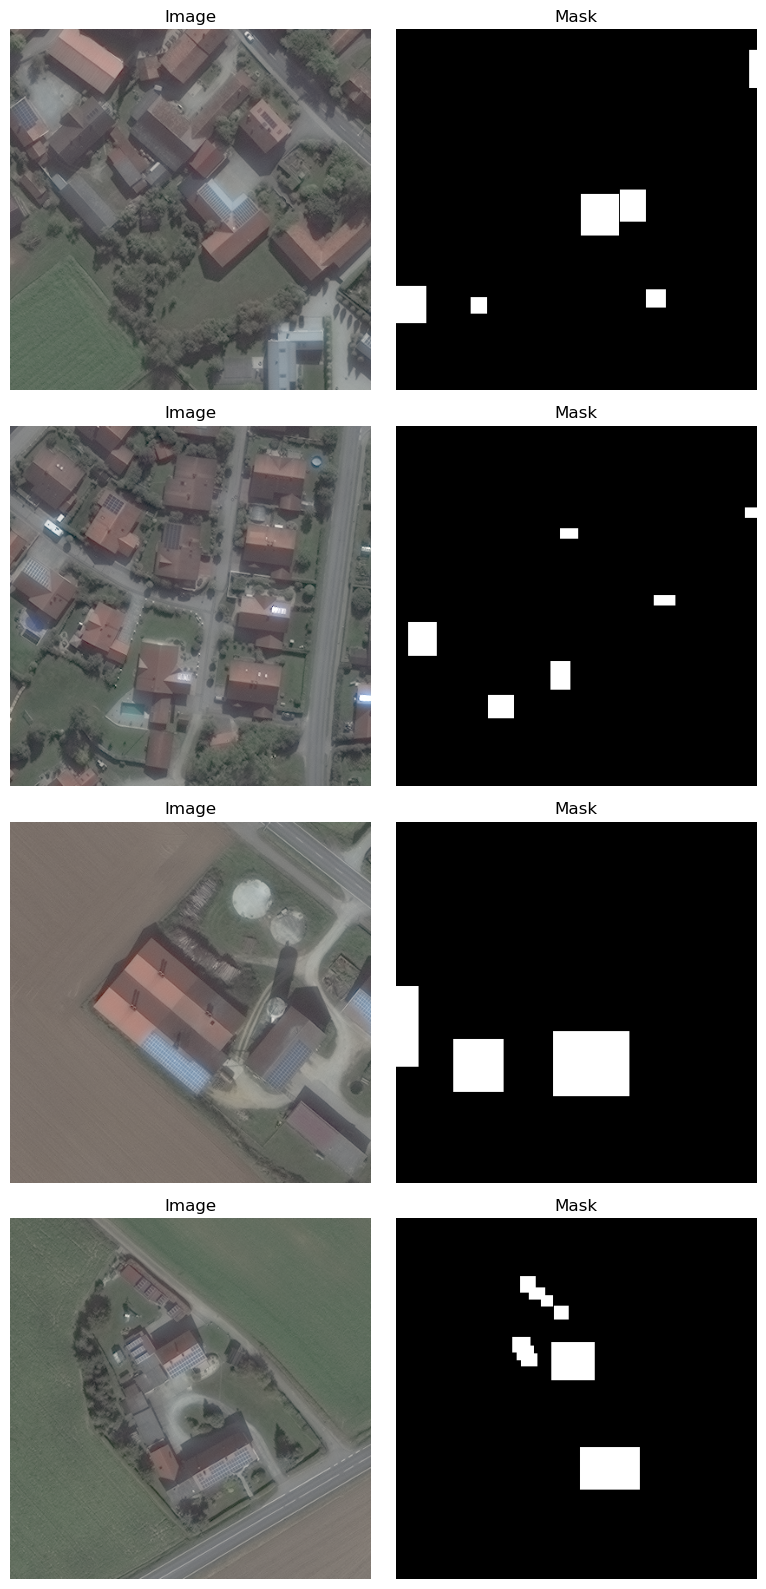


--- Training Model: UnetPlusPlus_timm-tf_efficientnet_lite4 ---


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting training for UnetPlusPlus_timm-tf_efficientnet_lite4 (native) with mps...
Data check: Image dir 'datasets/raw/images/maxar_hd_south_germany_PV_OD/image_chips_native', Mask dir 'datasets/raw/labels/maxar_hd_south_germany_PV_OD/masks_native' exist.


wandb: Currently logged in as: avega to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/Users/alejandovega/miniforge3/envs/eo-pv-cv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/alejandovega/Documents/grad_studies/UPRRP_CCOM_MS/tesis/PV_segmentation_and_energy_forecasting/CCOM_MS_Spring_2025_EO_PV_research/datasets/model_artifacts/checkpoints/UnetPlusPlus_timm-tf_efficientnet_lite4/native exists and is not empty.

  | Name          | Type                  | Params | Mode 
----------------------------------------------------------------
0 | model         | UnetPlusPlus          | 14.9 M | train
1 | dice_loss     | DiceLoss              | 0      | train
2 | bce_loss      | SoftBCEWithLogitsLoss | 0      | train
3 | train_metrics | MetricCollection      | 0      | train
4 | val_metrics   | MetricCollection      | 0      | train
----------------------------------------------------------------
14.9 M    Trainable params
0         Non-trainable params
14.9 M    Total params
59.416    Total estimated model params s

Setup: Train: 2034, Val: 508


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Error training UnetPlusPlus_timm-tf_efficientnet_lite4: MPS backend out of memory (MPS allocated: 9.15 GB, other allocations: 26.88 GB, max allowed: 36.27 GB). Tried to allocate 253.50 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Traceback (most recent call last):
  File "/var/folders/81/h1xdmxqn6l3_p3v3sw_s9cbw0000gp/T/ipykernel_8594/3649186423.py", line 85, in <module>
    trainer.fit(lightning_model, datamodule=data_module)
  File "/Users/alejandovega/miniforge3/envs/eo-pv-cv/lib/python3.12/site-packages/pytorch_lightning/trainer/trainer.py", line 539, in fit
    call._call_and_handle_interrupt(
  File "/Users/alejandovega/miniforge3/envs/eo-pv-cv/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py", line 47, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alejandovega/miniforge3/envs/eo-pv-cv/lib/python3.12/site-packages/pytorch_lightning/trainer/trainer.py", line 575, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/Users/alejandovega/miniforge3/envs/eo-pv-cv/lib/python3.12/site-packages/pytorch_lightning/trainer/trainer.py", line 982, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
lr-AdamW,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▅▆▇▇▇▇██
train_f1,▁▄▅▆▆▇▇██
train_iou,▁▄▅▅▆▇▇██
train_loss_epoch,█▅▃▃▂▂▂▁▁
train_loss_step,█▇▇▆▅▅▄▄▄▅▃▄▂▄▄▅▃▃▂▃▄▅▃▄▂▃▃▁▃▄▃▃▂▂▅▄▅▄▂▂
train_precision,▁▄▅▆▆▇▇██
train_recall,▁▃▄▃▅▆▆██
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
val_accuracy,▁▂▆▆▇▇▇██


In [ ]:
# sanity check for data loader (NOTE: sometimes seeing some cases of images seemingly flipped [on y-axis] )
data_module = PVSegmentationDataModule(
    image_dir=input_chips_dir, mask_dir=output_masks_dir,
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, # Set to 1 while testing if image matches label during sanity check
    val_split_ratio=VAL_SPLIT_RATIO, patch_size_pixels_dm=PATCH_SIZE_PIXELS, in_channels_dm=IN_CHANNELS
)
try:
    data_module.prepare_data()
    data_module.setup(stage='fit')

    # Visualize a sample batch from DataModule
    train_dl = data_module.train_dataloader()
    if train_dl and len(train_dl) > 0 :
        print("Visualizing a sample batch from DataModule's train_dataloader...")
        images, masks = next(iter(train_dl))
        def show_dm_batch(image_tensor, mask_tensor, num_samples=4, mean_val=None, std_val=None, in_channels=IN_CHANNELS):
            images_np = image_tensor[:num_samples].cpu().numpy()
            masks_np = mask_tensor[:num_samples].cpu().numpy()
            fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 4))
            if num_samples == 1: axes = np.array([axes])
            for i in range(num_samples):
                img = images_np[i].transpose(1, 2, 0)
                if mean_val and std_val:
                    m, s = np.array(mean_val), np.array(std_val)
                    img = s * img + m
                img = np.clip(img, 0, 1)
                if img.shape[-1] == 1: img = img.squeeze(-1) # For grayscale display

                mask = masks_np[i].squeeze()
                axes[i, 0].imshow(img, cmap='gray' if img.ndim==2 else None); axes[i, 0].set_title("Image"); axes[i, 0].axis('off')
                axes[i, 1].imshow(mask, cmap='gray'); axes[i, 1].set_title("Mask"); axes[i, 1].axis('off')
            plt.tight_layout(); plt.show()
        show_dm_batch(images, masks, mean_val=data_module.imagenet_mean, std_val=data_module.imagenet_std)
    else:
        print("Train dataloader from DataModule is empty or not available.")
        data_module = None # Prevent training if data is not loaded

except Exception as e:
    print(f"Error setting up DataModule or visualizing batch: {e}")
    data_module = None



In [ ]:
# setup local tensorboard logging
%load_ext tensorboard
%tensorboard --logdir tb_logs --port 6006

In [ ]:
if data_module.train_dataloader() and (data_module.val_dataloader() or VAL_SPLIT_RATIO == 0):
    for config_name, params in MODEL_CONFIGURATIONS.items():
        print(f"\n--- Training Model: {config_name} ---")
        lightning_model = PVSegmentationTask(
            model_arch=params['arch'], encoder_name=params['encoder'], encoder_weights=ENCODER_WEIGHTS,
            in_channels=IN_CHANNELS, num_classes=NUM_CLASSES, activation=TARGET_ACTIVATION,
            learning_rate=LEARNING_RATE)
        log_version = f"{SELECTED_RESOLUTION_TYPE}_{time.strftime('%Y%m%d-%H%M%S')}"
        tb_logger = TensorBoardLogger("tb_logs", name=config_name, version=log_version)
        # wandb.ai logger - ensure you have wandb installed (pip install wandb)
        # and WANDB_API_KEY environment variable set.
        # WANDB_PROJECT_NAME should be set in your .env or above.
        wandb_logger = WandbLogger(
            name=f"{config_name}-{log_version}", # Run name in W&B
            project=WANDB_PROJECT_NAME,
            # entity=WANDB_ENTITY, # Optional: your W&B team/entity
            log_model="all" # Log model checkpoints to W&B: True, "all", or False
        )
        checkpoint_dir = CHECKPOINT_DIR / config_name / SELECTED_RESOLUTION_TYPE
        checkpoint_cb = pl.callbacks.ModelCheckpoint(
            dirpath=checkpoint_dir,
            filename="{epoch}-{val_iou:.4f}", monitor="val_iou", mode="max", save_top_k=1
        )
        lr_monitor_cb = pl.callbacks.LearningRateMonitor(logging_interval='epoch')
        early_stop_cb = pl.callbacks.EarlyStopping(monitor="val_iou", patience=10, mode="max") # Increased patience

        trainer_kwargs = {"accelerator": ACCELERATOR, "devices": DEVICES, "max_epochs": NUM_EPOCHS,
                          "logger": [tb_logger, wandb_logger], # Use WandbLogger
                          "callbacks": [checkpoint_cb, lr_monitor_cb, early_stop_cb],
                          "precision": PRECISION_TRAINER}

        trainer = pl.Trainer(**trainer_kwargs)
        # if USE_TORCH_COMPILE:
        #     import torch._dynamo
        #     torch._dynamo.config.suppress_errors = True
        #     compile_mode = USE_TORCH_COMPILE if isinstance(USE_TORCH_COMPILE, str) else True
        #     lightning_model = torch.compile(lightning_model)
        #     print(f"PyTorch 2.0 compilation enabled with mode: {compile_mode}")
        try:
            print(f"Starting training for {config_name} ({SELECTED_RESOLUTION_TYPE}) with {ACCELERATOR}...")
            trainer.fit(lightning_model, datamodule=data_module)
            print(f"Training finished for {config_name} ({SELECTED_RESOLUTION_TYPE}).")
            if checkpoint_cb.best_model_path: print(f"Best model saved at: {checkpoint_cb.best_model_path}")
            wandb_logger.experiment.finish() # Finish W&B run
            print(f"Wandb run finished for {config_name} ({SELECTED_RESOLUTION_TYPE}).")
            # Optionally, save the model checkpoint to a specific directory
        except Exception as e:
            print(f"Error training {config_name}: {e}")
            traceback.print_exc()
            if wandb_logger.experiment: wandb_logger.experiment.finish(exit_code=1) # Finish run with error
            continue
else:
    print("DataLoaders not available. Skipping training. Check DataModule setup and data paths.")

In [18]:
torch._dynamo.list_backends()

['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'tvm']

## Model Evaluation and Prediction Visualization

After training, it's crucial to evaluate the model's performance on unseen data (typically the validation or a separate test set) and visualize its predictions to gain qualitative insights. This section demonstrates a basic approach to:

1.  **Loading the Best Model:** PyTorch Lightning's `ModelCheckpoint` callback saves the best performing model based on a monitored metric. We load this checkpoint for evaluation.
2.  **Making Predictions:** The loaded model is used to make predictions on a batch of data from the validation set.
3.  **Visualizing Results:** The original images, ground truth masks, and the model's predicted masks are displayed side-by-side for comparison.

This allows for a visual assessment of how well the model is segmenting the PV panels.

In [19]:
# %% --- 6. Evaluation & Visualization (Example) ---
if data_module and MODEL_CONFIGURATIONS:
    first_config_name = list(MODEL_CONFIGURATIONS.keys())[0]
    # Determine device for evaluation (mps, cuda, or cpu)
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        DEVICE_EVAL = torch.device("mps")
    elif torch.cuda.is_available():
        DEVICE_EVAL = torch.device("cuda")
    else:
        DEVICE_EVAL = torch.device("cpu")
    print(f"Using device for evaluation: {DEVICE_EVAL}")

    eval_resolution_type = SELECTED_RESOLUTION_TYPE
    if checkpoint_dir.exists():
        ckpt_files = sorted(list(checkpoint_dir.glob("*.ckpt")), key=os.path.getmtime, reverse=True)
        if ckpt_files:
            best_model_path_eval = ckpt_files[0] # Load the most recently saved best model
            print(f"\n--- Evaluating and Visualizing: {first_config_name} from {best_model_path_eval} ---")
            try:
                eval_model = PVSegmentationTask.load_from_checkpoint(best_model_path_eval, map_location=DEVICE_EVAL)
                eval_model.to(DEVICE_EVAL) # Ensure model is on the correct device
                eval_model.eval()

                current_eval_patch_size = 416 if eval_resolution_type == 'native' else 832
                # Check if DataModule needs re-setup for the evaluation resolution/patch size
                dm_params_match = (hasattr(data_module, 'patch_size_tuple') and
                                   data_module.patch_size_tuple == (current_eval_patch_size, current_eval_patch_size) and
                                   Path(data_module.image_dir).name == f"image_chips_{eval_resolution_type}")

                if not dm_params_match:
                    print(f"Re-setting up DataModule for evaluation: resolution {eval_resolution_type}, patch size {current_eval_patch_size}")
                    # Determine correct IMAGE_PARENT_DIR and MASK_PARENT_DIR for eval if they changed
                    eval_image_dir = IMAGE_PARENT_DIR / f"image_chips_{eval_resolution_type}"
                    eval_mask_dir = MASK_PARENT_DIR / f"masks_{eval_resolution_type}"

                    data_module_eval = PVSegmentationDataModule(
                        image_dir=str(eval_image_dir), mask_dir=str(eval_mask_dir),
                        batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                        val_split_ratio=VAL_SPLIT_RATIO, # or 0.99 for nearly all data if just for viz
                        patch_size_pixels_dm=current_eval_patch_size,
                        in_channels_dm=IN_CHANNELS
                    )
                    data_module_eval.prepare_data()
                    data_module_eval.setup(stage='fit') # or 'test' if you have a test_dataloader
                    val_loader_eval = data_module_eval.val_dataloader()
                    dm_for_viz = data_module_eval
                else:
                    val_loader_eval = data_module.val_dataloader()
                    dm_for_viz = data_module

                if val_loader_eval and len(val_loader_eval) > 0:
                    images_eval, masks_gt_eval = next(iter(val_loader_eval))
                    images_eval = images_eval.to(DEVICE_EVAL) # Move images to device

                    with torch.no_grad():
                        masks_pred_eval = eval_model(images_eval).cpu() # Move predictions to CPU for numpy/PIL

                    unnorm_transform = transforms.Compose([
                        transforms.Normalize(mean=[0.]*IN_CHANNELS, std=[1/s for s in data_module.imagenet_std]),
                        transforms.Normalize(mean=[-m for m in data_module.imagenet_mean], std=[1.]*IN_CHANNELS),
                        transforms.ToPILImage()
                    ])
                    masks_gt_pil = [transforms.ToPILImage()(m.cpu()) for m in masks_gt_eval]
                    if eval_model.hparams.activation is None: masks_pred_eval = torch.sigmoid(masks_pred_eval)
                    masks_pred_binary_pil = [transforms.ToPILImage()((m > 0.5).float().cpu()) for m in masks_pred_eval]

                    num_to_show = min(4, images_eval.size(0))
                    fig, axes = plt.subplots(num_to_show, 3, figsize=(12, num_to_show * 4))
                    if num_to_show == 1: axes = np.array([axes]) # Ensure axes is always 2D for consistent indexing
                    for i in range(num_to_show):
                        img_pil = unnorm_transform(images_eval[i].cpu()) # Move image to CPU before unnorm
                        axes[i, 0].imshow(img_pil); axes[i, 0].set_title("Image"); axes[i, 0].axis('off')
                        axes[i, 1].imshow(masks_gt_pil[i], cmap='gray'); axes[i, 1].set_title("Ground Truth"); axes[i, 1].axis('off')
                        axes[i, 2].imshow(masks_pred_binary_pil[i], cmap='gray'); axes[i, 2].set_title("Prediction"); axes[i, 2].axis('off')
                    plt.tight_layout(); plt.show()
                else: print("Validation dataloader not available or empty for visualization.")
            except Exception as e: print(f"Error during eval/viz of {first_config_name}: {e}"); import traceback; traceback.print_exc()
        else: print(f"No checkpoint file found in {checkpoint_dir} for {first_config_name}.")
    else: print(f"Checkpoint directory not found for {first_config_name}. Train first.")

Using device for evaluation: cuda
Checkpoint directory not found for UnetPlusPlus_resnet101. Train first.


## Next Steps and Further Experimentation

This notebook provides a foundational framework for PV panel segmentation. Here are some potential next steps and areas for further experimentation:

*   **Full Training Runs:** Increase `NUM_EPOCHS` for more comprehensive training.
*   **Hyperparameter Tuning:** Experiment with different learning rates, batch sizes, optimizer settings, and loss function weights.
*   **Explore More Architectures/Encoders:** Leverage the flexibility of `segmentation-models-pytorch` to try other model configurations available in `MODEL_CONFIGURATIONS` or add new ones.
*   **Data Augmentation:** Implement more sophisticated data augmentation techniques using `albumentations` within the `PVSegmentationDataset` or `PVSegmentationDataModule` to improve model generalization.
*   **Advanced Loss Functions:** Explore other loss functions or combinations suitable for imbalanced segmentation tasks.
*   **Test Set Evaluation:** Create a dedicated test set (if not already done) and evaluate the final model on it for an unbiased performance measure.
*   **Post-processing:** Implement post-processing steps (e.g., removing small predicted regions, morphological operations) to potentially improve segmentation quality.
*   **Larger Datasets:** Train on larger and more diverse datasets if available.
*   **Cross-Validation:** Implement k-fold cross-validation for more robust performance estimation.

Review the logs generated in the `tb_logs/` (TensorBoard) and `csv_logs/` directories, and inspect the saved model checkpoints in the `checkpoints/` directory to monitor training progress and select the best models.

In [20]:
# %% --- 7. Next Steps ---
print("\nNotebook execution finished.")
print("Next steps: Review logs in 'tb_logs/' and 'csv_logs/'. Check 'checkpoints/' for saved models.")
print("Consider increasing NUM_EPOCHS for full training runs.")


Notebook execution finished.
Next steps: Review logs in 'tb_logs/' and 'csv_logs/'. Check 'checkpoints/' for saved models.
Consider increasing NUM_EPOCHS for full training runs.


In [21]:
# %% --- 8. Export to CoreML and Quantization ---

# Only run this cell after successful training and evaluation

if 'eval_model' not in locals() or eval_model is None:
    print("No model available for export. Please run the evaluation cell first.")
else:
    print("Preparing model for export to CoreML...")

    try:
        import coremltools as ct
        from coremltools.models.neural_network import quantization_utils

        # Move model to CPU for export
        eval_model.to('cpu')
        eval_model.eval()

        # Define input shape
        example_input = torch.rand(1, IN_CHANNELS, PATCH_SIZE_PIXELS, PATCH_SIZE_PIXELS)

        # First, export to TorchScript format
        scripted_model = torch.jit.trace(eval_model, example_input)

        # Convert to CoreML
        print("Converting model to CoreML format...")
        mlmodel = ct.convert(
            scripted_model,
            inputs=[ct.TensorType(name="input", shape=example_input.shape)],
            convert_to="mlprogram",  # Use the newer ML Program format for better performance
            # compute_units="ALL"  # Can be "ALL", "CPU_ONLY", "CPU_AND_GPU", "CPU_AND_NE" (Neural Engine)
        )

        # Set model metadata
        mlmodel.short_description = "PV Segmentation using PyTorch Lightning and SMP"
        mlmodel.input_description['input'] = "Input image (RGB or multi-channel)"
        mlmodel.output_description['output'] = "Segmentation mask for PV panels"

        # Save the model
        output_path = Path("exported_models") / f"{first_config_name}_coreml.mlpackage"
        os.makedirs(output_path.parent, exist_ok=True)
        mlmodel.save(str(output_path))
        print(f"Model successfully exported to: {output_path}")

        # ---------- QUANTIZATION OPTIONS (COMMENTED) ----------

        # # FP16 Quantization
        # print("\nCreating FP16 quantized model...")
        # mlmodel_fp16 = quantization_utils.quantize_weights(mlmodel, nbits=16)
        # mlmodel_fp16.save(str(output_path).replace(".mlpackage", "_fp16.mlpackage"))
        # print("FP16 model saved.")

        # # INT8 Quantization (more aggressive compression, may affect accuracy)
        # # print("\nCreating INT8 quantized model...")
        # # mlmodel_int8 = quantization_utils.quantize_weights(mlmodel, nbits=8)
        # # mlmodel_int8.save(str(output_path).replace(".mlpackage", "_int8.mlpackage"))
        # # print("INT8 model saved.")

        # # For even more advanced quantization with calibration:
        # # from coremltools.optimize.coreml import create_quantized_model
        # # mlmodel_quantized = create_quantized_model(
        # #    mlmodel,
        # #    calibration_data=create_image_generator(calibration_images),
        # #    multiarray_dtype='int8'
        # # )

    except ImportError as e:
        print(f"CoreML export failed: {e}")
        print("Please install coremltools using: pip install coremltools")
    except Exception as e:
        print(f"Error during CoreML export: {e}")
        import traceback
        traceback.print_exc()


No model available for export. Please run the evaluation cell first.


## Datasets Overview

The training and evaluation of PV segmentation models rely on diverse, publicly available datasets. Many of these datasets are located in [Zenodo](https://zenodo.org/), a general-purpose open-access repository developed under the European OpenAIRE program and operated by CERN. Others are hosted in figshare, a web-based platform for sharing research data and other types of content. The rest are hosted in GitHub repositories or other open-access data platforms.

The dataset labels are available in a variety of formats, including CSV, GeoJSON, GeoPackage, ESRI shapefiles, raw raster masks, and GeoParquet. For this notebook, we assume that these datasets have been preprocessed into image patches and corresponding *raster* segmentation masks.

Here is a list of some prominent Solar Panel dataset publications, their first authors, DOI links, and approximate number of labels, which can be sources for preparing data for this notebook:

-   **"Distributed solar photovoltaic array location and extent dataset for remote sensing object identification"** - K. Bradbury, 2016 | [paper DOI](https://doi.org/10.1038/sdata.2016.106) | [dataset DOI](https://doi.org/10.6084/m9.figshare.3385780.v4) | polygon annotations for 19,433 PV modules in 4 cities in California, USA
-   **"A solar panel dataset of very high resolution satellite imagery to support the Sustainable Development Goals"** - C. Clark et al, 2023 | [paper DOI](https://doi.org/10.1038/s41597-023-02539-8) | [dataset DOI](https://doi.org/10.6084/m9.figshare.22081091.v3) | 2,542 object labels (per spatial resolution)
-   "A harmonised, high-coverage, open dataset of solar photovoltaic installations in the UK" - D. Stowell et al, 2020** | [paper DOI](https://doi.org/10.1038/s41597-020-00739-0) | [dataset DOI](https://zenodo.org/records/4059881) | 265,418 data points (over 255,000 are stand-alone installations, 1067 solar farms, and rest are subcomponents within solar farms)
-   "Georectified polygon database of ground-mounted large-scale solar photovoltaic sites in the United States" - K. Sydny, 2023 | [paper DOI](https://doi.org/10.1038/s41597-023-02644-8) | [dataset DOI](https://www.sciencebase.gov/catalog/item/6671c479d34e84915adb7536) | 4186 data points
-   "Vectorized solar photovoltaic installation dataset across China in 2015 and 2020" - J. Liu et al, 2024 | [paper DOI](https://doi.org/10.1038/s41597-024-04356-z) | [dataset link](https://github.com/qingfengxitu/ChinaPV) | 3,356 PV labels (inspect quality!)
-   *"Multi-resolution dataset for photovoltaic panel segmentation from satellite and aerial imagery"* - H. Jiang, 2021 | [paper DOI](https://doi.org/10.5194/essd-13-5389-2021) | [dataset DOI](https://doi.org/10.5281/zenodo.5171712) | 3,716 samples of PV data points
- **"A crowdsourced dataset of aerial images with annotated solar photovoltaic arrays and installation metadata"** - G. Kasmi, 2023 | [paper DOI](https://doi.org/10.1038/s41597-023-01951-4) | [dataset DOI](https://doi.org/10.5281/zenodo.6865878) | > 28K points of PV installations; 13K+ segmentation masks for PV arrays; metadata for 8K+ installations
-   "An Artificial Intelligence Dataset for Solar Energy Locations in India" - A. Ortiz, 2022 | [paper DOI](https://doi.org/10.1038/s41597-022-01499-9) | [dataset link 1](https://researchlabwuopendata.blob.core.windows.net/solar-farms/solar_farms_india_2021.geojson) or [dataset link 2](https://raw.githubusercontent.com/microsoft/solar-farms-mapping/refs/heads/main/data/solar_farms_india_2021_merged_simplified.geojson) | 117 geo-referenced points of solar installations across India
- **"GloSoFarID: Global multispectral dataset for Solar Farm IDentification in satellite imagery"** - Z. Yang, 2024** | [paper DOI](https://doi.org/10.48550/arXiv.2404.05180) | [dataset DOI](https://github.com/yzyly1992/GloSoFarID/tree/main/data_coordinates) | 6,793 PV samples across 3 years (double counting of samples)
-   "A global inventory of photovoltaic solar energy generating units" - L. Kruitwagen et al, 2021 | [paper DOI](https://doi.org/10.1038/s41586-021-03957-7) | [dataset DOI](https://doi.org/10.5281/zenodo.5005867) | 50,426 for training, cross-validation, and testing; 68,661 predicted polygon labels
-   "Harmonised global datasets of wind and solar farm locations and power" - S. Dunnett et al, 2020 | [paper DOI](https://doi.org/10.1038/s41597-020-0469-8) | [dataset DOI](https://doi.org/10.6084/m9.figshare.11310269.v6) | 35272 PV installations

In [22]:
# # %% --- 9. Interactive Visualization Slideshow ---

# from IPython.display import HTML, Image, display
# import os
# from pathlib import Path
# import ipywidgets as widgets
# import matplotlib.pyplot as plt
# import glob

# def create_slideshow(image_dir="report/assets/visualizations", height=500):
#     """Create an interactive slideshow from images in the specified directory.

#     Args:
#         image_dir: Path to directory containing the screenshots/images
#         height: Height in pixels for the display area

#     Returns:
#         Interactive widget displaying the slideshow
#     """
#     # Create directory if it doesn't exist
#     os.makedirs(image_dir, exist_ok=True)

#     # Find all image files
#     image_extensions = ["jpg", "jpeg", "png", "gif"]
#     image_files = []
#     for ext in image_extensions:
#         image_files.extend(glob.glob(os.path.join(image_dir, f"*.{ext}")))
#         image_files.extend(glob.glob(os.path.join(image_dir, f"*.{ext.upper()}")))  # Include uppercase extensions

#     image_files = sorted(image_files)  # Sort alphabetically

#     if not image_files:
#         print(f"No images found in {image_dir}")
#         print(f"Please add your screenshots to the {image_dir} directory")
#         print(f"Supported formats: {', '.join(image_extensions)}")
#         return None

#     # Create widgets
#     slider = widgets.IntSlider(
#         value=0,
#         min=0,
#         max=len(image_files)-1,
#         step=1,
#         description='Image:',
#         continuous_update=False,
#         layout=widgets.Layout(width='50%')
#     )

#     prev_button = widgets.Button(
#         description='Previous',
#         disabled=False,
#         button_style='',
#         tooltip='Previous image',
#         icon='arrow-left'
#     )

#     next_button = widgets.Button(
#         description='Next',
#         disabled=False,
#         button_style='',
#         tooltip='Next image',
#         icon='arrow-right'
#     )

#     image_widget = widgets.Image(
#         layout=widgets.Layout(height=f"{height}px"),
#     )

#     title_widget = widgets.HTML(
#         layout=widgets.Layout(height='auto')
#     )

#     # Define callback functions
#     def on_slider_change(change):
#         index = change['new']
#         display_image(index)

#     def on_prev_button_click(b):
#         if slider.value > 0:
#             slider.value -= 1

#     def on_next_button_click(b):
#         if slider.value < len(image_files) - 1:
#             slider.value += 1

#     def display_image(index):
#         filename = image_files[index]
#         with open(filename, 'rb') as f:
#             image_widget.value = f.read()

#         base_filename = os.path.basename(filename)
#         title_widget.value = f"<div style='text-align: center; font-weight: bold;'>{base_filename} ({index + 1}/{len(image_files)})</div>"

#     # Attach callbacks to widgets
#     slider.observe(on_slider_change, names='value')
#     prev_button.on_click(on_prev_button_click)
#     next_button.on_click(on_next_button_click)

#     # Display initial image
#     display_image(0)

#     # Arrange widgets
#     button_box = widgets.HBox([prev_button, next_button])
#     main_box = widgets.VBox([title_widget, image_widget, slider, button_box])

#     return main_box

# # Create and display the slideshow widget
# slideshow = create_slideshow()

# if slideshow:
#     display(slideshow)
# else:
#     # Create directory structure if it doesn't exist
#     viz_dir = "report/assets/visualizations"
#     os.makedirs(viz_dir, exist_ok=True)

#     # Display placeholder image with instructions
#     plt.figure(figsize=(10, 6))
#     plt.text(0.5, 0.5, f"Add your screenshots to:\n{os.path.abspath(viz_dir)}",
#              ha='center', va='center', fontsize=16, wrap=True)
#     plt.axis('off')
#     plt.title("Interactive Slideshow - Setup Instructions", fontsize=18)
#     plt.tight_layout()
#     plt.show()

#     print("\nTo use the slideshow:")
#     print(f"1. Add your screenshot images to: {os.path.abspath(viz_dir)}")
#     print("2. Make sure they're in jpg, jpeg, png, or gif format")
#     print("3. Re-run this cell to see the interactive slideshow")
#     print("\nTip: You can change the images directory by modifying the argument to create_slideshow()")